### Analyzing firefighters calls

In [ ]:
# TODO: Write down the project description

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
import contextily as ctx

#### a). Load the data

In [12]:
# Load the data
data = pd.read_csv("../data/processed/den_haag_ff.csv")
print(f"Total number of records collected : {data.shape[0]}")

# Format the pmeTimeStamp column
data["pmeTimeStamp"] = pd.to_datetime(data["pmeTimeStamp"])

Total number of records collected : 25374


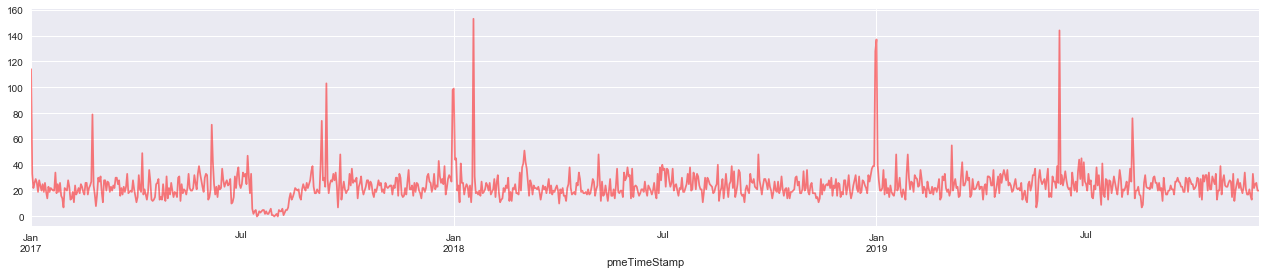

In [13]:
# Plot the data
data.set_index('pmeTimeStamp').groupby(pd.Grouper(freq='D')).count()['pmeId'].plot(figsize=(22,4), color='red', alpha=.5);

#### b). Select the period

The number of firefigthers calls made from 2018-12-30 00:00:00 to 2019-01-02 00:00:00 : 304


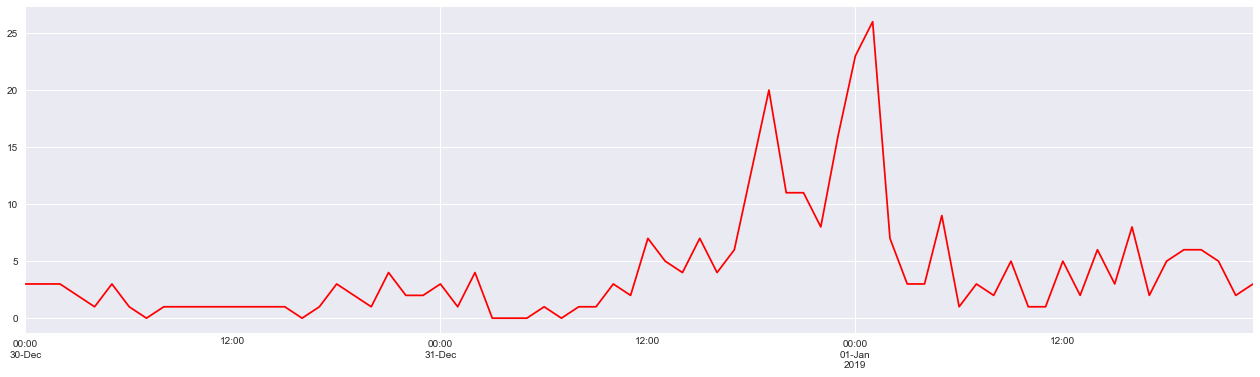

In [14]:
# Select the period

# # 2018 New Year's Eve
# begin = pd.to_datetime("2017-12-30")
# end = pd.to_datetime("2018-01-02")

# 2019 New Year's Eve
year = '2019'
begin = pd.to_datetime("2018-12-30")
end = pd.to_datetime("2019-01-02")

df = data[data["pmeTimeStamp"] > begin]
df = df[df["pmeTimeStamp"] < end]

print(f"The number of firefigthers calls made from {begin} to {end} : {df.shape[0]}")

# # Plot it
ax = df.set_index('pmeTimeStamp').groupby(pd.Grouper(freq='H')).count()['pmeId'].plot(figsize=(22,6), color='red')
ax.set_xlabel('');

#### c). Check whether the calls were made from The Hague region

In [15]:
# Clean the coordinates
df['pmeLatitude'] = df['pmeLatitude'].replace(to_replace='\\N', value=np.nan)
df['pmeLongitude'] = df['pmeLongitude'].replace(to_replace='\\N', value=np.nan)

df['pmeLatitude'] = df['pmeLatitude'].dropna()
df['pmeLongitude'] = df['pmeLongitude'].dropna()

df["pmeLatitude"] = df["pmeLatitude"].astype(float)
df["pmeLongitude"] = df["pmeLongitude"].astype(float)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df["pmeLongitude"], df["pmeLatitude"])
)
gdf.crs = {"init": "epsg:4326"}

In [16]:
# Load municipal borders
polygon = gpd.read_file('../data/processed/den_haag_borders.json', driver="GeoJSON")

Seems to be alright.

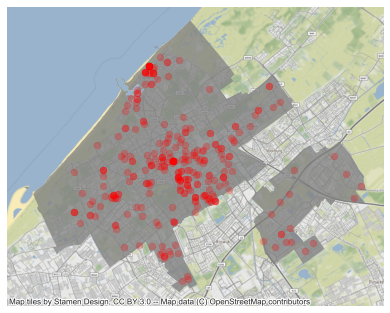

In [17]:
ax = polygon.to_crs(epsg=3857).plot(color='gray', alpha=.75)
gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=.25);
ctx.add_basemap(ax=ax)
plt.axis('off');

#### d). Check the calls by type

Unique categories (I did a manual check, maybe missed something):

* Buitenbrand afval/rommel = External fire waste
* Brandmelding Melding Via Openbaar = Meldsysteem Fire Reporting Via Public Reporting System
* Ongeval spoorvervoer letsel = Rail accident injury
* Gebouwbrand woning = Building fire house
* Assistentie ambu = Assistance ambulance
* Assistentie politie = Assistance police
* Stormschade = Storm damage
* Wateroverlast = Waterlogging 
* Liftopsluiting = Lift confinement
* Buitenbrand container = Outdoor fire container
* Persoon te water = Person in the water
* Voertuigbrand = Vehicle fire
* Dienstverlening = Services

In [10]:
# Specify the categories of interest
categories = ['Buitenbrand afval/rommel', 'Gebouwbrand woning', 'Buitenbrand container', 'Voertuigbrand']

In [11]:
# Select only the calls due to Vehicle Fire
i = []
for index, row in gdf['pmeStrippedMessage'].iteritems():
    if 'Voertuigbrand' in row:
        i.append(index)

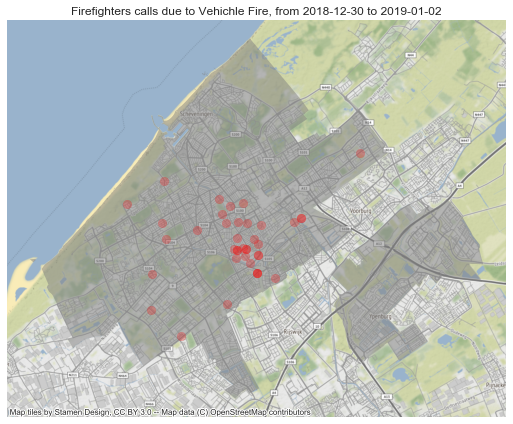

In [12]:
# Plot it
ax = polygon.to_crs(epsg=3857).plot(color='gray', alpha=.5, figsize=(8,6))
gdf.loc[i,:].to_crs(epsg=3857).plot(ax=ax, color='red', alpha=.25, markersize=75);
ctx.add_basemap(ax=ax) # url=ctx.sources.ST_TONER_BACKGROUND)
ax.set_title(f'Firefighters calls due to Vehichle Fire, from {begin.date()} to {end.date()}')
plt.axis('off')
plt.tight_layout();

In [13]:
# Get the rest categories
j = []
for index, row in gdf['pmeStrippedMessage'].iteritems():
    for category in categories:
        if category in row:
            j.append(index)
            break

In [14]:
# Save the data
gdf.loc[j,:].to_file(f'../data/processed/den_haag_ff_calls_cleaned_{year}.json', driver='GeoJSON')

In [15]:
# Display calls by category
df = pd.DataFrame(gdf[['pmeTimeStamp', 'pmeStrippedMessage']].loc[j,:])
l = []
for message in df['pmeStrippedMessage'].tolist():
    for category in categories:
        if category in message:
            l.append(category)
            break

In [16]:
df['pmeCategoryOnly'] = l

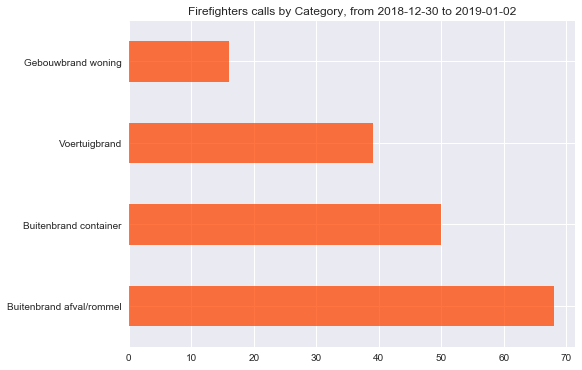

In [17]:
df['pmeCategoryOnly'].value_counts().plot.barh(figsize=(8,6), color='orangered', alpha=.75);
plt.title(f'Firefighters calls by Category, from {begin.date()} to {end.date()}');

In [18]:
t = gdf.loc[j,:]
t['pmeCategoryOnly'] = l 

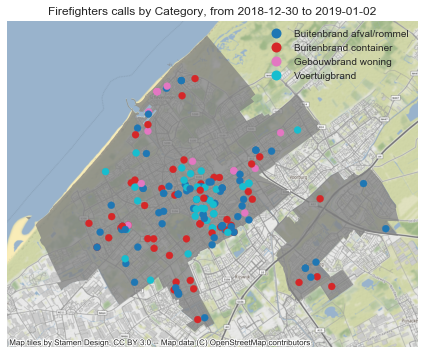

In [19]:
ax = polygon.to_crs(epsg=3857).plot(color='gray', alpha=.75, figsize=(8,6))
t.to_crs(epsg=3857).plot(ax=ax, column='pmeCategoryOnly', legend=True);
ctx.add_basemap(ax=ax)
ax.set_title(f'Firefighters calls by Category, from {begin.date()} to {end.date()}')
plt.axis('off');